# Calulate Bed Probe Code

This notebook calculate the gcode required to probe the Trium delta printer. In principle, the code can be adapted to any delta printer by appropriate changes to the contants.

The sample points are calculated on a regular grid according to the user-specified sampling density, plus a series of additional points near the towers and in the centre of the bed.  The points are carefully selected to present three points on lines partway to the tower. These three points correspond to the points on a smaller four-point test.  The idea is to use the detailed sampling less often and then use the four-point sample test for regular levelling.

## Repetier Logfile

It is somewhat of a mission to do a long multi-sample mesh probe with Repetier. For a few samples the log display on the screen is sufficiently large to capture all data.  But for the 84-sample probe file created in this notebook, the screen log area refreshes and loses some of the information. To capture the full log, you must use the Repetier log file on disk.  The procedure is as follows:

- Switch on the disk log file capture (by default is is off) using the Config/Preferences menu setting.
- Close Repetier to make the change effective.
- Execute the bed probing with the 84 sample file.
- Close Repetier again to force the completion of the log file writing to disk.
- Open the log file from disk in the directory `%USER%\AppData\Local\RepetierHost` ( you can change the location in the preferences setting.
- Cut the portion containing the information.


## Input data

The settings shown below were carefully tuned to achieve the following objectives:
- Keep the PWM fans clear of the Y and Z towers.
- Keep the probe on the bed.
- Include the centre as a valid sample point.
- Include three sample points on a line between the centre and a tower, near a tower, such that the point can be compared with a simpler sampling procedure used for bed levelling.
- Give a reasonable sampling density at regular intervals.
- Do regular G28 homing commands. 

It was found that doing only one G28 at the start of the procedure is not sufficient, it leads to very large errors towards the end of the run.  It takes a long time to G28 at every sample, but the present arrangement of G28 at every second sample provides sufficient accuracy (but the procedure takes a long time to do the frequent G28s).

The code below starts with a full and large grid of sampling points and then eliminates the illegal sample points.  Towards the Y tower some sampling points have to be dropped to prevent the fan from moving in into the Y-tower belt.

The gcode file created with this data set creates 84 samples over most of the bed.

In [50]:
# to prepare and load constants

import numpy as np
from scipy.interpolate import interp2d
import pyradi.ryplot as ryplot
import pandas as pd
%matplotlib inline

np.set_printoptions(linewidth=120)

bedRadius = 110. 
towerRadius = 180. # centre to belts
towerClearance = 70. # distance nozzle to outmost fan part
probeRadius = 104. # don't probe near edges
samplintx = 18.125 # sample interval in mm
samplinty = 22 # sample interval in mm
maxsize = 2.5 *  bedRadius  # number of points spread over this distance
xoffset = -33.5 # probe offset from nozzle
yoffset = -5. # probe offset from nozzle
numg28 = 2 # number of samples between g28 
numg30=5 # number of probes per one position

In [51]:
# to create the grid
x = np.arange(0,maxsize,samplintx)
x = np.sort(np.append(x,-x[1:]))
y = np.arange(0,maxsize,samplinty)
y = np.sort(np.append(y,-y[1:]))

# xx,yy are the required probe positions
xx,yy = np.meshgrid(x,y)
radius = np.sqrt(xx*xx+yy*yy)
# xn, yn are the nozzle positions corresponding to the above probe positions
xn = xx - xoffset
yn = yy - yoffset

# p = ryplot.Plotter(1,1,1,figsize=(8,7));
# p.meshContour(1,xx,yy,radius,contLabel=True,cbarshow=True);
# print(np.unique(xx))
# print(np.unique(yy))


unique x values:
[-90.625 -72.5   -54.375 -36.25  -18.125   0.     18.125  36.25   54.375  72.5    90.625]
unique y values:
[-88. -66. -44. -22.   0.  22.  44.  66.  88.]


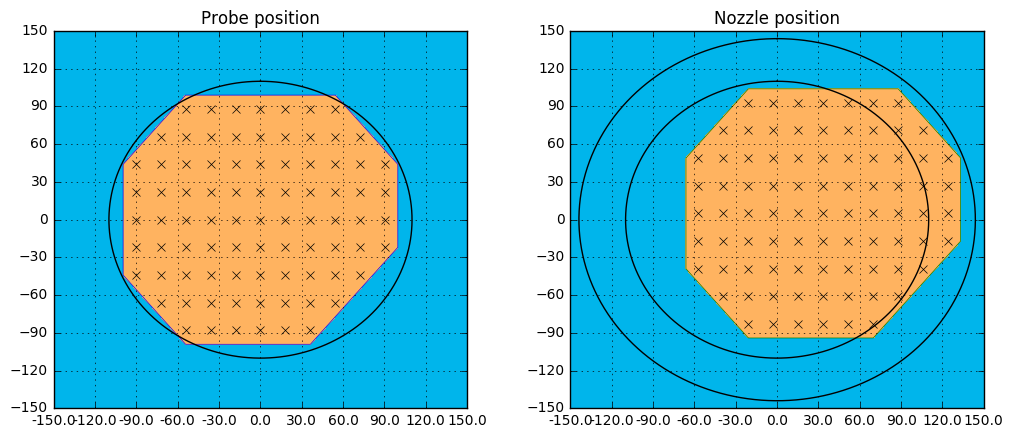

In [52]:
# to eliminate the 'illegal' points
valid = np.ones((xx.shape))
# Y tower, cutout around the tower by a sloping line, X limit and Y limit
coffset =  - (towerRadius-towerClearance) / np.tan(np.pi * 30. / 180.) 
slope = 2.
valid =  np.logical_and(valid,
                        np.logical_or(yy >  slope*xx+coffset,
                                      np.logical_or(yy>-30.,xx<50.)))
# Z tower
valid =  np.logical_and(valid, yy  <  towerRadius-towerClearance    ) 
# probe area within the head
valid = np.logical_and(valid, radius <= probeRadius)

# create circles for plotting below
rang = np.linspace(0,2*np.pi,360)
xb = bedRadius * np.sin(rang)
yb = bedRadius * np.cos(rang)
xt = (bedRadius+np.sqrt(xoffset*xoffset+yoffset*yoffset)) * np.sin(rang)
yt = (bedRadius+np.sqrt(xoffset*xoffset+yoffset*yoffset)) * np.cos(rang)

p = ryplot.Plotter(1,1,2,figsize=(12,5));
p.meshContour(1,xx,yy,valid,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Probe position');
p.plot(1,xb,yb,plotCol=['k']);
p.plot(1,xx[valid],yy[valid],plotCol=['k'],markers=['x'],linestyle='');


p.meshContour(2,xx-xoffset,yy-yoffset,valid,contLabel=False,cbarshow=False,drawGrid=True,
              levels=1,pltaxis=[-150,150,-150,150],ptitle='Nozzle position');
p.plot(2,xb,yb,plotCol=['k']);
p.plot(2,xx[valid]-xoffset,yy[valid]-yoffset,plotCol=['k'],markers=['x'],linestyle='');
p.plot(2,xt,yt,plotCol=['k']);

print('unique x values:\n{}'.format(np.sort(np.unique(xx[valid]))))
print('unique y values:\n{}'.format(np.sort(np.unique(yy[valid]))))


In [53]:
# to write the gcode file
lst = []
for ix in range(0,xn.shape[0]):
    for iy in range(0,xn.shape[1]):
        if valid[ix,iy]:
            lst.append([xn[ix,iy],yn[ix,iy],xx[ix,iy],yy[ix,iy]])


df = pd.DataFrame(np.asarray(lst),columns=['xn','yn','xx','yy'])

header = """
;  probe the Trium bed in {} positions, {} times at each point
M119 ; print a separator in the log file
M105 ; get temperatures
G21  ; set units to mm
G90  ; absolute positioning
G28  ; home: reset coord sys by reading MAX endstops\n
""".format(df.shape[0],numg30)

footer = """
G28 ; home: reset coord sys by reading MAX endstops\n
"""

#note: we write nozzle position out here, not probe position
filename = 'g30-zprobe-{}-{}.gcode'.format(df.shape[0],numg30)
print('Writing {}'.format(filename))
with open(filename,'w') as fo:
    fo.write(header)
    for ie,idx in enumerate(df.index.values):
        strln = 'G0 X{:.3f} Y{:.3f} Z10 F3000\n'.format(df.ix[idx]['xn'],df.ix[idx]['yn'])
        fo.write(strln)
        for i in range(0,numg30):
            fo.write('G30\n')
        if not ie % numg28:
            fo.write('G28  ; home: reset coord sys by reading MAX endstops\n')
            
    fo.write(footer)

Writing g30-zprobe-84-5.gcode


Time 10:19:49.537 
Bed temperature is 75.2 deg C
Nozzle temperature is 28.7 deg C
x     -90.62  -72.50  -54.37  -36.25  -18.12   0.00    18.13   36.25   54.38  \
y                                                                              
22.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN  -0.238  -0.210   
44.0   -0.04   0.008   0.014  -0.100  -0.156  -0.230  -0.258  -0.268  -0.244   
66.0     NaN  -0.194   0.026  -0.108  -0.122  -0.220  -0.240  -0.260  -0.234   
88.0     NaN     NaN  -0.034  -0.130  -0.080  -0.224  -0.170  -0.202  -0.146   

x      72.50   76.50  
y                     
22.0  -0.154  -0.126  
44.0  -0.148  -0.126  
66.0  -0.100     NaN  
88.0     NaN     NaN  


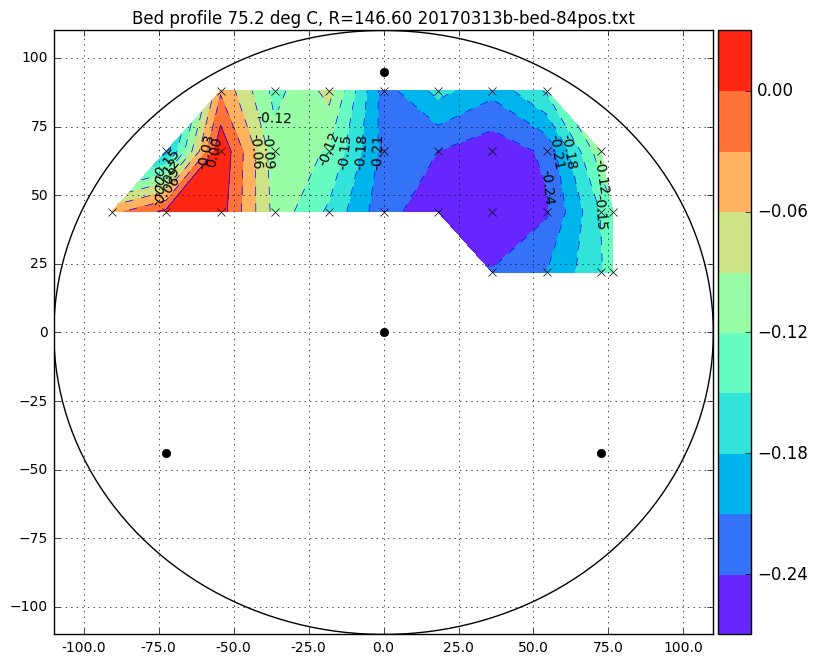

In [54]:
##
def plotBed(filename,zProbeTrigger,shimThickness):
    validlines = []
    tdone = False
    with open(filename,'r') as fin:
        lines = fin.readlines()
        for line in lines:
            line = line.strip()
            lstl = line.split(' ')
            # only use lines with Bed X: in them for dataframe
            if 'Bed X:' in line:
                # remove unwanted clutter, keep only x,y,z
                validlines.append([float(lstl[i]) for i in [4,6,8]])
            # if temperature lines, get values
            if not tdone and 'ok' in line and 'T:' in line and 'B:' in line:
                print('Time {} '.format(lstl[0]))
                bedtemp = lstl[5].split(':')[1]
                print('Bed temperature is {} deg C'.format(bedtemp))
                print('Nozzle temperature is {} deg C'.format(lstl[3].split(':')[1]))
                tdone = True
            if 'M665' in line:
                drad = lstl[6][1:]

                
# 22:50:02.719 : echo:  M665 L278.00 R147.50 S100.00 A0.00 B0.00 C0.00
           

    # 
    cmark = np.asarray([[0,0],[-72.5,-44],[72.5,-44],[0,95]])

    # make pandas dataframe
    df = pd.DataFrame(validlines,columns=['x','y','z'])
    # the g30 command already corrected for the x,y offset
    # correct for probe offset and friction shim to get to metal
    df['x'] = df['x'] 
    df['y'] = df['y'] 
    df['z'] = df['z'] - (zProbeTrigger - shimThickness)
    
    dfr = df.groupby(by=['x','y']).aggregate(np.mean).reset_index().sort_values(by=['x','y'])
#     print(dfr)
#     print(dfr.columns)
#     print(np.max(dfr['z'])-np.min(dfr['z']))
    
    xUni = np.sort(dfr['x'].unique())
    yUni = np.sort(dfr['y'].unique())
    xUm,yUm = np.meshgrid(xUni,yUni)

    dfp = dfr.pivot(index='y', columns='x', values='z')
    print(dfp)
    
    p = ryplot.Plotter(1,1,1,figsize=(9,8));
    # q = ryplot.Plotter(2,figsize=(15,15));
    p.meshContour(1,xUm,yUm,dfp,cbarshow=True,drawGrid=True,
                  levels=10,pltaxis=[-110,110,-110,110],contLabel=True,contFonSz=10,
                  ptitle='Bed profile {} deg C, R={} {}'.format(bedtemp,drad,filename));

    p.plot(1,xb,yb,plotCol=['k']);
    p.plot(1,dfr['x'],dfr['y'],markers=['x'],linestyle='',plotCol=['k'],linewidths=[1]);
    p.plot(1,cmark[:,0],cmark[:,1],markers=['o'],linestyle='',plotCol=['k'],linewidths=[1]);

plotBed('20170313b-bed-84pos.txt',zProbeTrigger=0.7,shimThickness=0.1)
